In [144]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import pandas as pd;
import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import pickle

In [3]:
X_train = pd.read_csv('./data/processed/X_train.csv', na_filter=False)
X_val = pd.read_csv('./data/processed/X_val.csv', na_filter=False)
X_test = pd.read_csv('./data/processed/X_test.csv', na_filter=False)

y_train = pd.read_csv('./data/processed/y_train.csv', na_filter=False)
y_val = pd.read_csv('./data/processed/y_val.csv', na_filter=False)
y_test = pd.read_csv('./data/processed/y_test.csv', na_filter=False)

In [4]:
feature_names = X_train.columns
categorical_features = ['MainBranch', 'Employment', 'Country', 'EdLevel', 'OrgSize', 'Currency',
                'OpSys', 'SOVisitFreq', 'SOAccount', 'SOPartFreq', 'SOComm', 'NEWOtherComms',
                'Gender', 'Ethnicity', 'SurveyLength', 'SurveyEase']

In [5]:
def cat_feature_to_label(dataset, dataset_val, dataset_test, categorical_features):
    categorical_features_indices = []
    data = dataset.copy()
    data_val = dataset_val.copy()
    data_test = dataset_test.copy()
    for i, name in enumerate(data.columns):
        if name in categorical_features:
            categorical_features_indices.append(i)
    categorical_names = {}
    for feature in categorical_features_indices:
        le = LabelEncoder()
        le.fit(data.iloc[:, feature])
        data.iloc[:, feature] = le.transform(data.iloc[:, feature])
        data_val.iloc[:, feature] = le.transform(data_val.iloc[:, feature])
        data_test.iloc[:, feature] = le.transform(data_test.iloc[:, feature])
        categorical_names[feature_names[feature]] = le.classes_
    return data, data_val, data_test, categorical_features_indices, categorical_names

In [6]:
X_train_label, X_val_label, X_test_label, categorical_features_indices, categorical_names = \
cat_feature_to_label(X_train, X_val, X_test, categorical_features)

In [167]:
model = CatBoostRegressor()
model.load_model('catboost_model');

# model_clf = CatBoostClassifier()
# model_clf.load_model('catboost_clf_model');

# model_clf_fnums = CatBoostClassifier()
# model_clf_fnums.load_model('catboost_clf_model_features_is_nums');

## Важность признаков

### SHAP

In [168]:
explainer = shap.TreeExplainer(model)

In [171]:
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=categorical_features))

Посмотрим на важность признаков. В данном варианте категориальные признаки никак дополнительно не обрабатывались (поле является строкой). На экран выведем топ-20 признаков (чтоб изменить, нужно поменять значение параметра `max_display`). В основном видим, что низкие значения параметра SHAP value вносят отрицательный вклад в ответ, а высокие -- положительный (наоборот для признаков `DatabaseHaveWorkeWith_MySQL ` и `WebframeHaveWorkedWith_jQuery`).

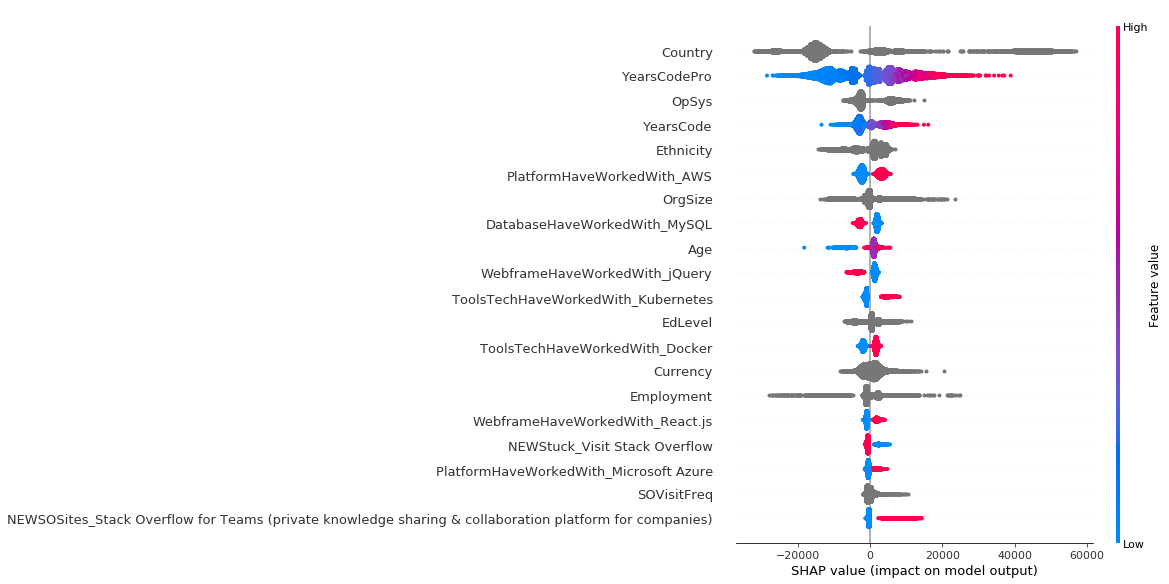

In [172]:
shap.summary_plot(shap_values, X_train, max_display=20)

Теперь закодируем категориальные признаки. Посмотрим есть ли зависимость зарплаты от метки значения.

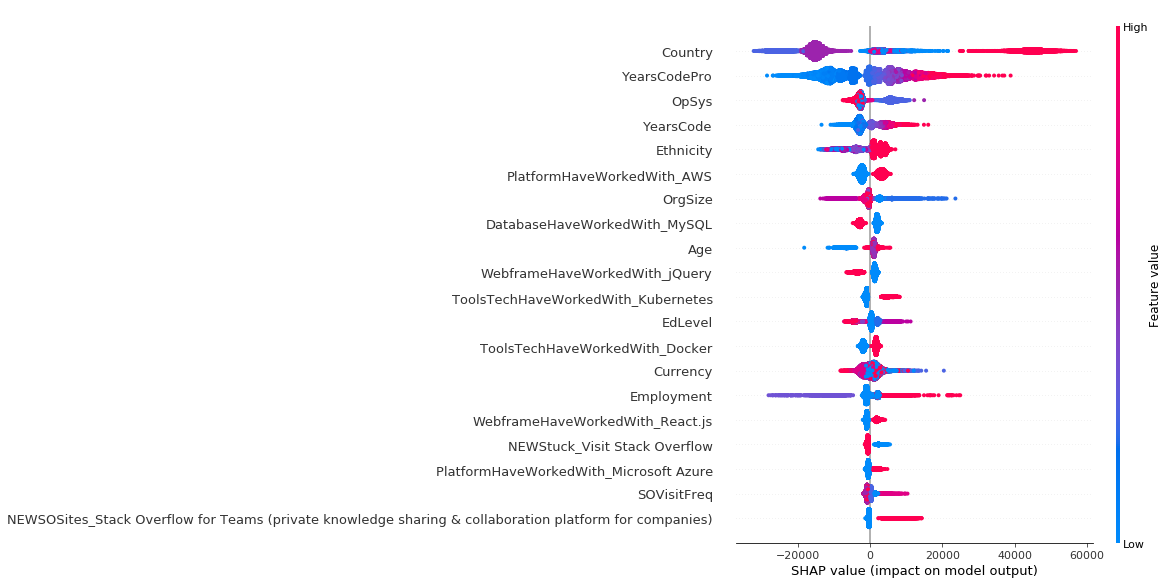

In [11]:
shap.summary_plot(shap_values, X_train_label, max_display=20)

Да, действительно, от значения категориального признака зависит зарплата. Например, для признака `Country` значение `United States of America` закодировано значением 5 (наибольшим), и видим, что высокие значения признака вносят положительный вклад в предсказание зарплаты.

А вот с признаком `OpSys` дело обстоит очень интересно: значения `Windows` и `Windows Subsystem for Linux (WSL)` закодированы соответственно метками 5 и 6, а `Linux-based` и `MacOS` 1 и 2. Видим, ОС Windows вносит отрицательный вклад, в то время как Linux и Mac -- положительный.

Для удобства анализа выведем на экран метку и значение для каждого категориального признака:

In [13]:
for feature_name, values in categorical_names.items():
    print(feature_name)
    for i, val in enumerate(values):
        print(i, '\t', val)
    print()

MainBranch
0 	 I am a developer by profession
1 	 I am not primarily a developer, but I write code sometimes as part of my work

Employment
0 	 Employed full-time
1 	 Employed part-time
2 	 I prefer not to say
3 	 Independent contractor, freelancer, or self-employed
4 	 N/A
5 	 Retired

Country
0 	 Canada
1 	 Germany
2 	 India
3 	 Other
4 	 United Kingdom of Great Britain and Northern Ireland
5 	 United States of America

EdLevel
0 	 Bachelor’s degree (B.A., B.S., B.Eng., etc.)
1 	 Master’s degree (M.A., M.S., M.Eng., MBA, etc.)
2 	 Other
3 	 Other doctoral degree (Ph.D., Ed.D., etc.)
4 	 Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)
5 	 Some college/university study without earning a degree

OrgSize
0 	 1,000 to 4,999 employees
1 	 10,000 or more employees
2 	 100 to 499 employees
3 	 2 to 9 employees
4 	 20 to 99 employees
5 	 Other

Currency
0 	 CAD	Canadian dollar
1 	 EUR European Euro
2 	 GBP	Pound sterling
3 	 INR	Indian rupee
4 	 Other
5 	 US

### Catboost

Так как наилучшее качество показал Catboost, оценим важность признаков и с его помощью. Стоит отметить, что он может оценить важность признаков, используя SHAP values, но мы так делать не будем.

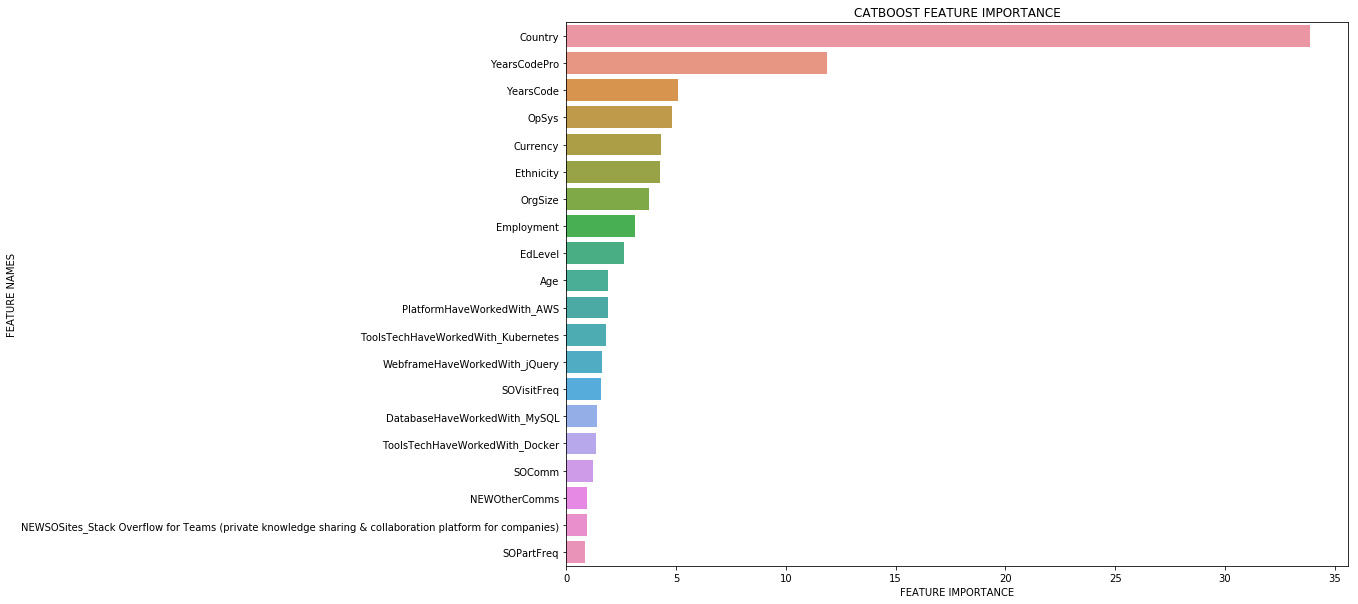

In [14]:
def plot_feature_importance(importance, names, max_display=20):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(14,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:max_display], y=fi_df['feature_names'][:max_display])
    #Add chart labels
    plt.title('CATBOOST FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    
plot_feature_importance(model.get_feature_importance(), feature_names, max_display=20)

Топ-20 признаков для CatBoost и SHAP почти совпадает, но порядок немного другой, хотя в обоих случаях `Country` выделен как самый важный признак.

## Важность признаков по классам

Так как решается задача регрессии, а требуется анализ по классам, преобразуем целевую переменную следующим образом:

пусть объекты, с зарплатой не более значения медианы на обучающей выборке, принадлежат классу 0, а остальные объекты -- классу 1.

In [15]:
MEDIAN = np.median(y_train)

def get_categorial_y(y):
    y = np.array(y)
    y[np.where(y <= MEDIAN)] = 0
    y[np.where(y > MEDIAN)] = 1
    y = y.ravel()
    return y

y_train_cat = get_categorial_y(y_train)
y_val_cat = get_categorial_y(y_val)
y_test_cat = get_categorial_y(y_test)

По этому критерию поделим значения shap values на значения для класса 0 и для класса 1.

In [16]:
rows_class_0 = np.where(y_train_cat==0)[0]
rows_class_1 = np.where(y_train_cat==1)[0]

X_train_label_class_0 = X_train_label.iloc[rows_class_0, :]
X_train_label_class_1 = X_train_label.iloc[rows_class_1, :]

shap_values_class_0 = shap_values[rows_class_0]
shap_values_class_1 = shap_values[rows_class_1]

Выведем на экран важность признаков для каждого класса.

### Важность признаков для класса 0 (зарплата <= медианы)

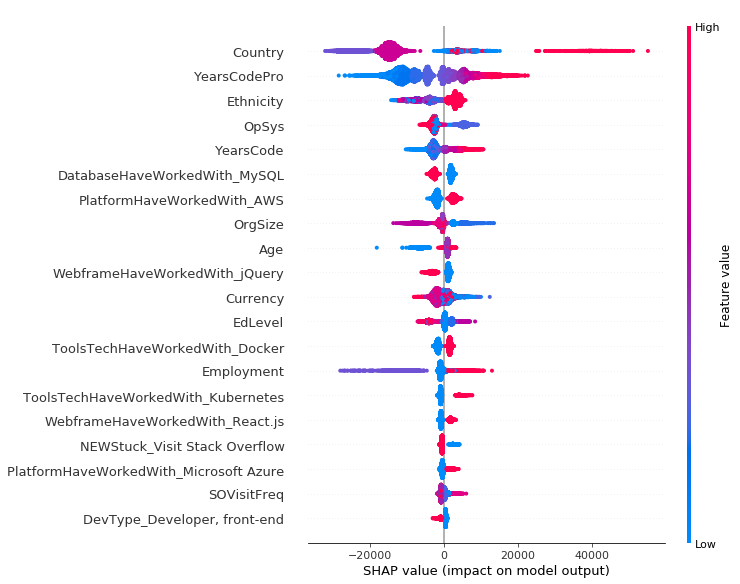

In [17]:
shap.summary_plot(shap_values_class_0, X_train_label_class_0, feature_names, max_display=20)

### Важность признаков для класса 0 (зарплата > медианы)

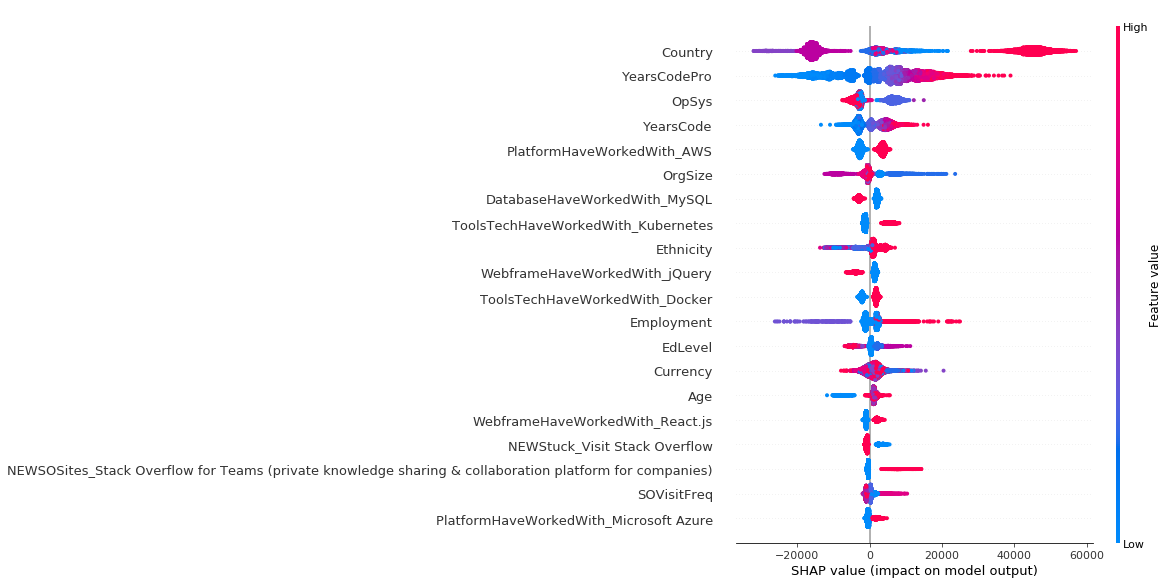

In [18]:
shap.summary_plot(shap_values_class_1, X_train_label_class_1, feature_names, max_display=20)

SHAP values для разных классов похожи, хотя порядок важности признаков немного отличается. Интуитивно казалось, что картинки должны быть зеркальным отражением друг друга, хотя на практике вышло иначе. 

Важность признаков внутри класса и между классами существенно не меняется.

### Разбор примеров

Рассмотрим примеры, где модель предсказывает верно и где ошибается. Так как решается задача регрессии, то в качестве верного предсказания будем брать не точное совпадение предсказания, а предсказания с небольшой абсолютной ошибкой. В качестве неверного предсказания будем брать предсказание с большой абсолютной ошибкой.

In [97]:
small_but_big_predict = 3545
big_but_small_predict = 6217
big_and_big_predict = 8088
small_and_small_predict = 8140

examples  = [small_but_big_predict, big_but_small_predict, big_and_big_predict, small_and_small_predict]

In [175]:
X_test_ohe.shape

(8143, 107)

In [82]:
def get_predict(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test_ = y_test.values.reshape((y_test.shape[0], ))
    return y_test_, y_pred

Выберем 4 примера из тестовой выборки и проанализируем их

## CatBoost

In [133]:
y_test_, y_pred = get_predict(model, X_test, y_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.iloc[examples,:])

In [140]:
i = 0
example = examples[i]
print('Модель ошиблась: большое предсказание при маленьком значении')
print('Test ID: ', example)
print("Предсказание: %.0f" % y_pred[example])
print("Реальное значение: %.0f" % y_test_[example])

rip, pid = (i, example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rip], X_test.iloc[pid], feature_names=feature_names)

Модель ошиблась: большое предсказание при маленьком значении
Test ID:  3545
Предсказание: 164950
Реальное значение: 48000


In [141]:
i = 1
example = examples[i]
print('Модель ошиблась: маленькое предсказание при большом значении')
print('Test ID: ', example)
print("Предсказание: %.0f" % y_pred[example])
print("Реальное значение: %.0f" % y_test_[example])

rip, pid = (i, example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rip], X_test.iloc[pid], feature_names=feature_names)

Модель ошиблась: маленькое предсказание при большом значении
Test ID:  6217
Предсказание: 29015
Реальное значение: 233496


In [142]:
i = 2
example = examples[i]
print('Модель верно ответила: большое предсказание при большом значении')
print('Test ID: ', example)
print("Предсказание: %.0f" % y_pred[example])
print("Реальное значение: %.0f" % y_test_[example])

rip, pid = (i, example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rip], X_test.iloc[pid], feature_names=feature_names)

Модель верно ответила: большое предсказание при большом значении
Test ID:  8088
Предсказание: 159546
Реальное значение: 165000


In [143]:
i = 3
example = examples[i]
print('Модель верно ответила: маленькое предсказание при маленьком значении')
print('Test ID: ', example)
print("Предсказание: %.0f" % y_pred[example])
print("Реальное значение: %.0f" % y_test_[example])

rip, pid = (i, example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rip], X_test.iloc[pid], feature_names=feature_names)

Модель верно ответила: маленькое предсказание при маленьком значении
Test ID:  8140
Предсказание: 16902
Реальное значение: 13620


## Линейная модель

In [148]:
X_train_ohe = pd.read_csv('./data/processed/X_train_ohe.csv', na_filter=False)
X_val_ohe = pd.read_csv('./data/processed/X_val_ohe.csv', na_filter=False)
X_test_ohe = pd.read_csv('./data/processed/X_test_ohe.csv', na_filter=False)

In [149]:
with open('linear_model.pickle', 'rb') as f:
    model = pickle.load(f)

In [154]:
feature_names_ohe = X_train_ohe.columns

In [160]:
y_test_, y_pred = get_predict(model, X_test_ohe, y_test)

explainer = shap.Explainer(model, X_train_ohe, feature_names=feature_names_ohe)
shap_values = explainer.shap_values(X_test_ohe.iloc[examples,:])

In [161]:
i = 0
example = examples[i]
print('Модель ошиблась: большое предсказание при маленьком значении')
print('Test ID: ', example)
print("Предсказание: %.0f" % y_pred[example])
print("Реальное значение: %.0f" % y_test_[example])

rip, pid = (i, example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rip], X_test_ohe.iloc[pid], feature_names=feature_names_ohe)

Модель ошиблась: большое предсказание при маленьком значении
Test ID:  3545
Предсказание: 716790
Реальное значение: 48000


In [164]:
i = 1
example = examples[i]
print('Модель ошиблась: маленькое предсказание при большом значении')
print('Test ID: ', example)
print("Предсказание: %.0f" % y_pred[example])
print("Реальное значение: %.0f" % y_test_[example])

rip, pid = (i, example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rip], X_test_ohe.iloc[pid], feature_names=feature_names_ohe)

Модель ошиблась: маленькое предсказание при большом значении
Test ID:  6217
Предсказание: 113078
Реальное значение: 233496


In [165]:
i = 2
example = examples[i]
print('Модель верно ответила: большое предсказание при большом значении')
print('Test ID: ', example)
print("Предсказание: %.0f" % y_pred[example])
print("Реальное значение: %.0f" % y_test_[example])

rip, pid = (i, example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rip], X_test_ohe.iloc[pid], feature_names=feature_names_ohe)

Модель верно ответила: большое предсказание при большом значении
Test ID:  8088
Предсказание: 416549
Реальное значение: 165000


In [166]:
i = 3
example = examples[i]
print('Модель верно ответила: маленькое предсказание при маленьком значении')
print('Test ID: ', example)
print("Предсказание: %.0f" % y_pred[example])
print("Реальное значение: %.0f" % y_test_[example])

rip, pid = (i, example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[rip], X_test_ohe.iloc[pid], feature_names=feature_names_ohe)

Модель верно ответила: маленькое предсказание при маленьком значении
Test ID:  8140
Предсказание: 143411
Реальное значение: 13620


# Нейронная сеть

TODO